In [1]:
import torch
import torch.nn.functional as Func
import matplotlib.pyplot as plt

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

vocab_size = len(itos)
vocab_size

27

In [5]:
context_len = 3

In [6]:
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        expanded_word = '.'*context_len + w
        for i, (x, y) in enumerate(zip(expanded_word, w+'.')):
            X.append([stoi[expanded_word[k]] for k in range(i, i+context_len)])
            Y.append(stoi[y])
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

X, Y = build_dataset(words)

In [18]:
import random

random.seed(42)

random.shuffle(words)
training_split = int(0.8*len(words))
dev_split = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:training_split])
X_dev, Y_dev = build_dataset(words[training_split:dev_split])
X_test, Y_test = build_dataset(words[dev_split:])

In [158]:
context_len = 3 # context length: how many characters do we take to predict the next one?
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((context_len * n_embed, n_hidden), generator=g) * (5/3) / ((n_embed * context_len)**0.5) # * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum([p.nelement() for p in parameters])

12097

In [104]:
(torch.randn(1000)*0.2).std()

tensor(0.1999)

In [105]:
(5/3) / (30**0.5)

0.3042903097250923

tensor(0.0248) tensor(0.9957)
tensor(-0.0051) tensor(0.9954)


(array([2.00844832e-05, 4.01689664e-05, 2.00844832e-05, 8.03379327e-05,
        1.00422416e-04, 2.20929315e-04, 3.81605180e-04, 6.42703462e-04,
        1.20506899e-03, 2.16912418e-03, 3.83613629e-03, 5.68390874e-03,
        1.04037623e-02, 1.64692762e-02, 2.63508419e-02, 4.18962319e-02,
        6.63189634e-02, 9.66867020e-02, 1.41535353e-01, 2.03435730e-01,
        2.70718749e-01, 3.39809371e-01, 3.96909557e-01, 4.36797340e-01,
        4.31495037e-01, 3.95061784e-01, 3.19524043e-01, 2.48384803e-01,
        1.86765609e-01, 1.32557589e-01, 8.98579777e-02, 5.71604391e-02,
        3.76584060e-02, 2.30369022e-02, 1.35771106e-02, 8.31497604e-03,
        4.59934665e-03, 2.95241903e-03, 1.90802590e-03, 9.64055192e-04,
        6.22618978e-04, 2.81182764e-04, 2.20929315e-04, 6.02534495e-05,
        8.03379327e-05, 4.01689664e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.01689664e-05]),
 array([-5.94711494, -5.69816654, -5.44921814, -5.20026974, -4.95132133,
        -4.70237293, 

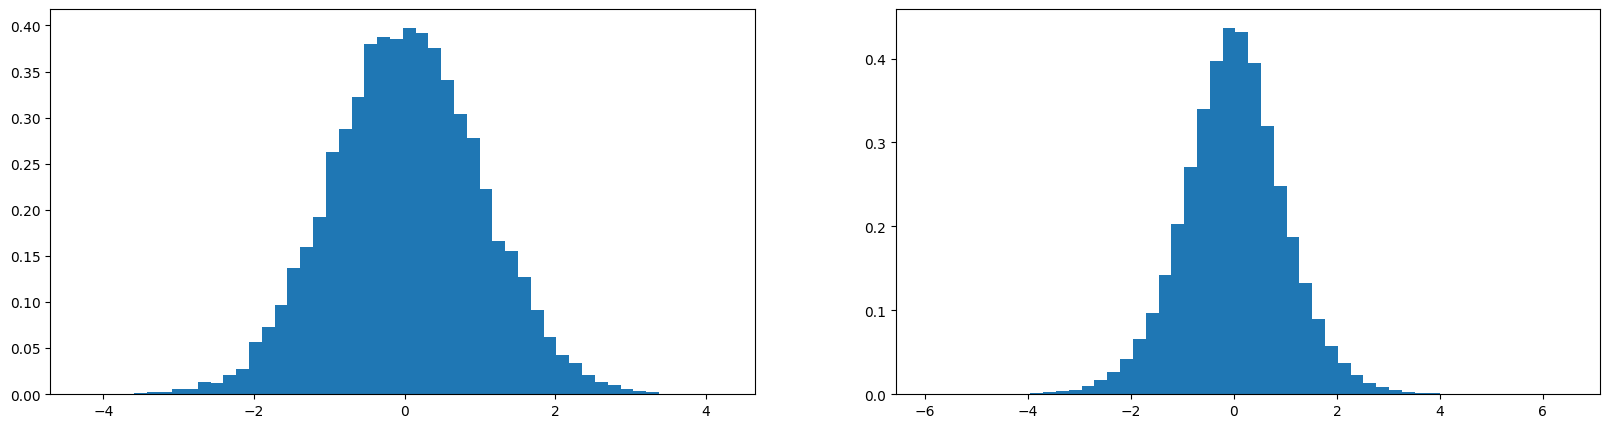

In [100]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [159]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):    
    batch_index = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    #forward
    emd = C[X_batch]
    h_preact = emd.view(emd.shape[0], -1) @ W1# + b1 # hidden layer pre-activation

    bnmeani = h_preact.mean(0, keepdim=True)
    bnstdi = h_preact.std(0, keepdim=True)
    
    h_preact = bngain * (h_preact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2 # output layer
    
    loss = Func.cross_entropy(logits, Y_batch) # + mse # N x 1


    #backward
    for p in parameters:
        p.grad = None

    loss.backward()
    
    # update
    learning_rate = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    
    for p in parameters:
        p.data += -learning_rate * p.grad #

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    #break

      0/ 200000: 3.3014
  10000/ 200000: 2.4789
  20000/ 200000: 2.3364
  30000/ 200000: 2.1072
  40000/ 200000: 2.0523
  50000/ 200000: 2.4329
  60000/ 200000: 2.2905
  70000/ 200000: 2.0826
  80000/ 200000: 2.0123
  90000/ 200000: 2.0183
 100000/ 200000: 2.4473
 110000/ 200000: 2.0486
 120000/ 200000: 2.1925
 130000/ 200000: 2.3583
 140000/ 200000: 2.2693
 150000/ 200000: 2.3672
 160000/ 200000: 2.0888
 170000/ 200000: 2.0872
 180000/ 200000: 2.4111
 190000/ 200000: 1.8808


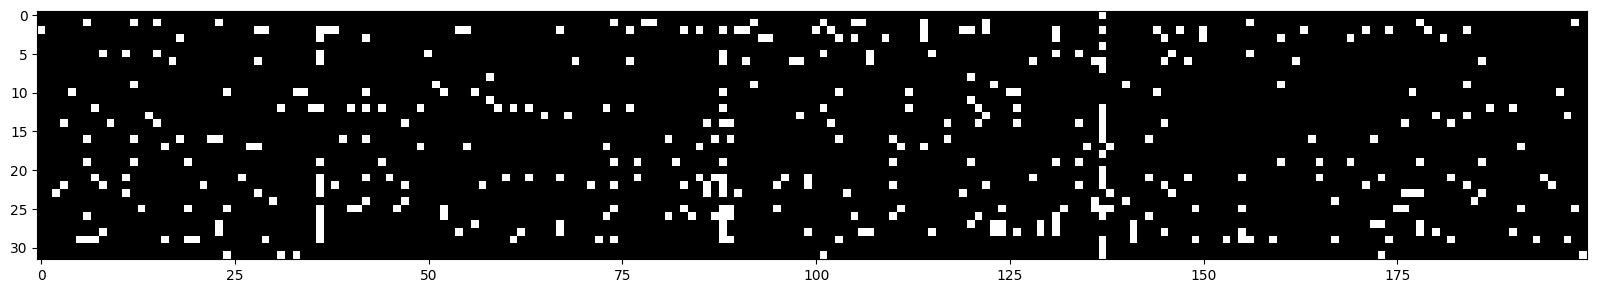

In [160]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([  2.,   2.,   3.,   2.,  13.,  13.,  12.,  19.,  21.,  28.,  39.,
         69.,  67.,  50.,  86., 137., 128., 183., 224., 253., 321., 311.,
        481., 580., 739., 469., 351., 322., 260., 255., 199., 143., 108.,
        118.,  89.,  65.,  62.,  44.,  40.,  26.,  17.,  14.,   8.,  12.,
          3.,   3.,   4.,   2.,   0.,   3.]),
 array([-5.16406679, -4.95198352, -4.73990025, -4.52781697, -4.3157337 ,
        -4.10365043, -3.89156715, -3.67948388, -3.46740061, -3.25531734,
        -3.04323406, -2.83115079, -2.61906752, -2.40698424, -2.19490097,
        -1.9828177 , -1.77073442, -1.55865115, -1.34656788, -1.13448461,
        -0.92240133, -0.71031806, -0.49823479, -0.28615151, -0.07406824,
         0.13801503,  0.3500983 ,  0.56218158,  0.77426485,  0.98634812,
         1.1984314 ,  1.41051467,  1.62259794,  1.83468122,  2.04676449,
         2.25884776,  2.47093103,  2.68301431,  2.89509758,  3.10718085,
         3.31926413,  3.5313474 ,  3.74343067,  3.95551394,  4.16759722,
 

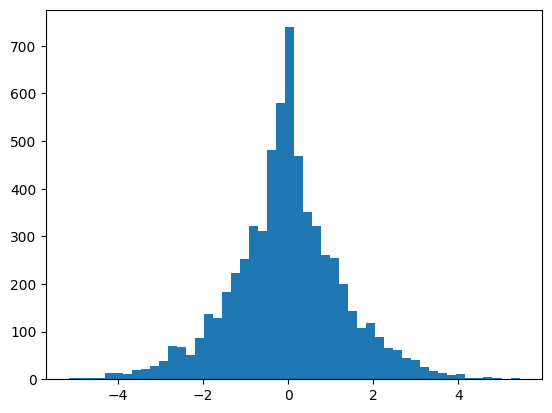

In [161]:
plt.hist(h_preact.view(-1).tolist(), 50)

(array([447., 227., 173., 164., 126., 108., 119., 117., 112., 105.,  87.,
         74.,  89.,  72.,  93.,  97., 131., 112.,  97.,  95., 135., 122.,
        115., 151., 148., 121., 118., 186.,  78.,  90., 110., 103.,  95.,
         90.,  66.,  80.,  93.,  81.,  91.,  98.,  85., 107.,  96.,  98.,
        131., 127., 146., 155., 194., 445.]),
 array([-9.99934614e-01, -9.59936675e-01, -9.19938736e-01, -8.79940797e-01,
        -8.39942858e-01, -7.99944919e-01, -7.59946980e-01, -7.19949042e-01,
        -6.79951103e-01, -6.39953164e-01, -5.99955225e-01, -5.59957286e-01,
        -5.19959347e-01, -4.79961408e-01, -4.39963470e-01, -3.99965531e-01,
        -3.59967592e-01, -3.19969653e-01, -2.79971714e-01, -2.39973775e-01,
        -1.99975836e-01, -1.59977897e-01, -1.19979959e-01, -7.99820197e-02,
        -3.99840808e-02,  1.38580799e-05,  4.00117970e-02,  8.00097358e-02,
         1.20007675e-01,  1.60005614e-01,  2.00003552e-01,  2.40001491e-01,
         2.79999430e-01,  3.19997369e-01,  3.59995

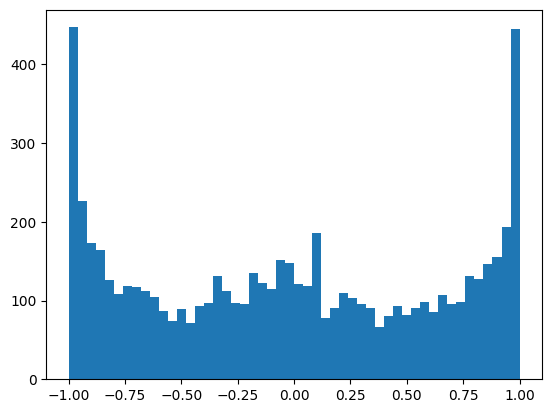

In [163]:
plt.hist(h.view(-1).tolist(), 50)

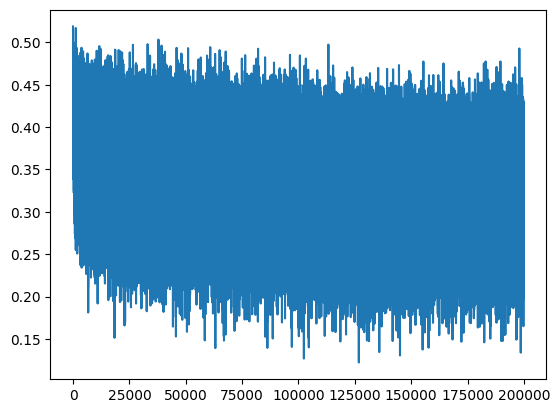

In [162]:
plt.plot(lossi)

In [164]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'dev': (X_dev, Y_dev),
        'test': (X_test, Y_test),
    }[split]

    emd = C[x]
    h_preact = emd.view(emd.shape[0], -1) @ W1 + b1
    
    bnmean = bnmean_running #h_preact.mean(0, keepdim=True)
    bnstd = bnstd_running #h_preact.std(0, keepdim=True)
    
    h_preact = bngain * (h_preact - bnmean) / bnstd + bnbias
    h = torch.tanh(h_preact)
                   
    logits = h @ W2 + b2
    loss = Func.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.0655484199523926
dev 2.1110422611236572


In [171]:
emd = C[X_train]
h_preact = emd.view(emd.shape[0], -1) @ W1 + b1
    
bnmean = h_preact.mean(0, keepdim=True)
bnstd = h_preact.std(0, keepdim=True)


def predict(n):
    g = torch.Generator().manual_seed(2147483647)

    for i in range(n):
        out = []
        context = [0] * context_len

        while True:
            x = torch.tensor([context])
            emd = C[x]
            h_preact = emd.view(emd.shape[0], -1) @ W1 # hidden layer pre-activation
            #print(h_preact)
            h_preact = bngain * ((h_preact - bnmean) / bnstd) + bnbias


            h = torch.tanh(h_preact)
            logits = h @ W2 + b2 # output layer
    
            probs = Func.softmax(logits, dim=1)

            pred_y = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()

            out.append(itos[pred_y])
            
            if pred_y == 0:
                break

            context = context[1:] + [pred_y]
            
        print(''.join(out))

predict(10)

dex.
mariah.
makilah.
tyharlonimitta.
nella.
kama.
darreliyah.
javari.
mari.
moriella.
